In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys, h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from deepomics import neuralnetwork as nn
from deepomics import utils, fit, visualize, saliency, metrics

import time as time
import helper
sys.path.append('../..')
import mutagenesisfunctions as mf
np.random.seed(247)
tf.set_random_seed(247)

In [2]:
def fom_convsal(X, layer, alphabet, filter_index, max_idx, nntrainer, sess, title='notitle', figsize=(15,2)
                , fig=None, pos=None, idx=None):
    
    eps = 1e-7
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get the neurons score for the mutations
    mut_scores = nntrainer.get_activations(sess, mutations, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #take the WT and put it into a dict for deepomics
    #WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get activations for the WT sequence
    #WT_score = nntrainer.get_activations(sess, WT, layer=layer)[:, max_idx[filter_index], :, filter_index]

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_scores.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    #norm_heat_mut = (heat_mut - WT_score) + eps
    #norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=4)

    return (heat_mut)

def fom_saliency(X, layer, alphabet, nntrainer, sess, title='notitle', figsize=(15,2), factor=4):

    ''' requires that deepomics is being used and the appropriate architecture has already been constructed
    Must first initialize the session and set best parameters

    layer is the activation layer we want to use as a string
    figsize is the figure size we want to use'''
    
    
    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get output or logits activations for the mutations
    mut_predictions = nntrainer.get_activations(sess, mutations, layer=layer)

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get output or logits activations for the WT sequence
    predictions = nntrainer.get_activations(sess, WT, layer=layer)

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - predictions[0]
    norm_heat_mut = utils.normalize_pwm(heat_mut, factor=factor)

    plt.figure(figsize=figsize)
    if title != 'notitle':
        plt.title(title)
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, 
                                        norm_heat_mut,
                                        alphabet=alphabet, 
                                        nt_width=400) 
    

def fom_heatmap(X, layer, alphabet, nntrainer, sess, factor=4, eps=0):

    #first mutate the sequence
    X_mut = mf.mutate(X, X.shape[1], X.shape[3])

    #take all the mutations and assign them into a dict for deepomics
    mutations = {'inputs': X_mut, 'targets': np.ones((X_mut.shape[0], 1))}
    #Get output or logits activations for the mutations
    mut_predictions = nntrainer.get_activations(sess, mutations, layer=layer)

    #take the WT and put it into a dict for deepomics
    WT = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
    #Get output or logits activations for the WT sequence
    predictions = nntrainer.get_activations(sess, WT, layer=layer)

    #shape the predictions of the mutations into the shape of a heatmap
    heat_mut = mut_predictions.reshape(X.shape[1],4).T
    
    #normalize the heat map rearrangement by minusing it by the true prediction score of that test sequence
    norm_heat_mut = heat_mut - predictions[0] + eps
    norm_heat_mut = utils.normalize_pwm(norm_heat_mut, factor=factor)

    return (heat_mut)

In [3]:
data_path = '../data/Synthetic_dataset.h5'
results_path = '../results'
params_path = utils.make_directory(results_path, 'model_params')
exp_path = utils.make_directory(results_path, 'FoM_layers')

# load dataset
train, valid, test = helper.load_synthetic_dataset(data_path)

test_model = helper.load_synthetic_models(data_path, dataset='test')
    
# get data shapes
input_shape = list(train['inputs'].shape)
input_shape[0] = None
output_shape = [None, train['targets'].shape[1]]

loading training data
loading cross-validation data
loading test data


###### Highest scored sequences according to DistNet

In [4]:
tf.reset_default_graph()

model_name = 'DistNet'
plot_path = utils.make_directory(exp_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)

# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)

activations = nntrainer.get_activations(sess, test, layer='output')

plot_index = np.argsort(activations[:,0])[::-1]

loading model from:  ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt


In [5]:
nnmodel.inspect_layers()

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 24)
layer3: conv1d_0_batch
(?, 200, 1, 24)
layer4: conv1d_0_active
(?, 200, 1, 24)
layer5: conv1d_0_dropout
(?, 200, 1, 24)
layer6: conv1d_1
(?, 195, 1, 32)
layer7: conv1d_1_batch
(?, 195, 1, 32)
layer8: conv1d_1_active
(?, 195, 1, 32)
layer9: conv1d_1_maxpool
(?, 65, 1, 32)
layer10: conv1d_1_dropout
(?, 65, 1, 32)
layer11: conv1d_2
(?, 60, 1, 48)
layer12: conv1d_2_batch
(?, 60, 1, 48)
layer13: conv1d_2_active
(?, 60, 1, 48)
layer14: conv1d_2_maxpool
(?, 15, 1, 48)
layer15: conv1d_2_dropout
(?, 15, 1, 48)
layer16: conv1d_3
(?, 12, 1, 64)
layer17: conv1d_3_batch
(?, 12, 1, 64)
layer18: conv1d_3_active
(?, 12, 1, 64)
layer19: conv1d_3_maxpool
(?, 4, 1, 64)
layer20: conv1d_3_dropout
(?, 4, 1, 64)
layer21: conv1d_4
(?, 1, 1, 96)
layer22: conv1d_4_batch
(?, 1,

In [6]:
# set best parameters
nntrainer.set_best_parameters(sess)

# test model
loss, mean_vals, std_vals = nntrainer.test_model(sess, train, name='test')

loading model from:  ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
  test  loss:		0.10861
  test  accuracy:	0.96248+/-0.00000
  test  auc-roc:	0.99330+/-0.00000
  test  auc-pr:		0.99256+/-0.00000


Look at the same sequences but with first order mutagenesis

INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/LocalNet/LocalNet_do_l2_bn_best.ckpt


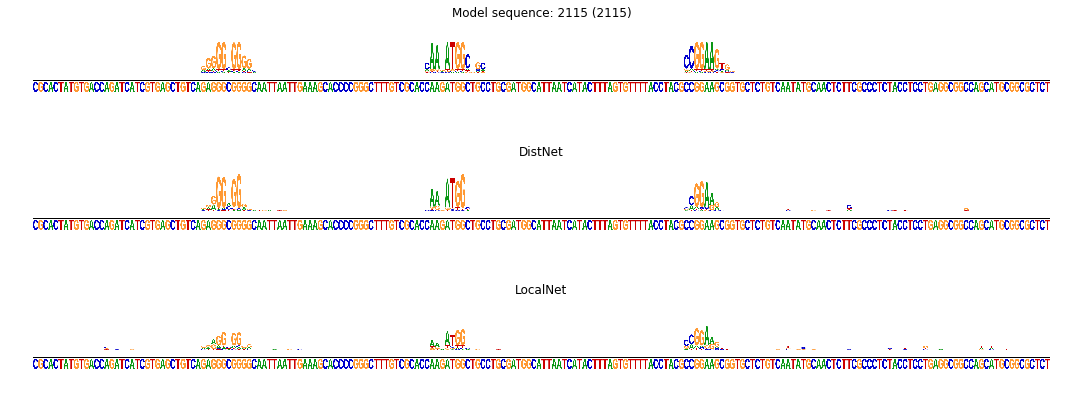

In [8]:
localvisfactor = 5
deepvisfactor = 5
normfactor = 4

for s in [2115]:
#for s in np.linspace(1000,2000,50).astype(int):
#for s in [4949, 5805,265,1120,1177,1723,1775,4005,4149,4262,4576,4656,5698]:
#for s in range(2):

    index = s#plot_index[s]
    X = np.expand_dims(test['inputs'][index], axis=0)
    X_model = test_model[index]


    fig = plt.figure(figsize=(15,6))
    plt.subplot(3,1,1)
    plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)

################################################################################################################    

    plt.subplot(3,1,2)
    model_name = 'DistNet'
    plt.title(model_name)
    model_path = utils.make_directory(params_path, model_name)
    file_path = os.path.join(model_path, model_name+'_do_l2_bn')

    # saliency parameters
    params = {'model_name': model_name, 
              'input_shape': input_shape, 
              'dropout_status': dropout_status,
              'l2_status': l2_status,
              'bn_status': bn_status,
              'model_path': file_path+'_best.ckpt',
             }
    
    tf.reset_default_graph()

    # build new graph
    model_layers, optimization, genome_model = helper.load_model(params['model_name'], params['input_shape'], 
                                                   params['dropout_status'], params['l2_status'], params['bn_status'])

    nnmodel = nn.NeuralNet()
    nnmodel.build_layers(model_layers, optimization, method='guided', use_scope=True)
    nntrainer = nn.NeuralTrainer(nnmodel, save='best', filepath=params['model_path'])

    # setup session and restore optimal parameters
    sess = utils.initialize_session(nnmodel.placeholders)
    nntrainer.set_best_parameters(sess, params['model_path'], verbose=0)

    saliency = fom_heatmap(X, 'dense_0_bias', 'dna', nntrainer, sess, factor=normfactor)
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, saliency, alphabet='dna', nt_width=50, norm_factor=deepvisfactor)

################################################################################################################    


    plt.subplot(3,1,3)
    model_name = 'LocalNet'
    plt.title(model_name)
    model_path = utils.make_directory(params_path, model_name)
    file_path = os.path.join(model_path, model_name+'_do_l2_bn')

    # saliency parameters
    params = {'model_name': model_name, 
              'input_shape': input_shape, 
              'dropout_status': dropout_status,
              'l2_status': l2_status,
              'bn_status': bn_status,
              'model_path': file_path+'_best.ckpt',
             }


    tf.reset_default_graph()

    # build new graph
    model_layers, optimization, genome_model = helper.load_model(params['model_name'], params['input_shape'], 
                                                   params['dropout_status'], params['l2_status'], params['bn_status'])

    nnmodel = nn.NeuralNet()
    nnmodel.build_layers(model_layers, optimization, method='guided', use_scope=True)
    nntrainer = nn.NeuralTrainer(nnmodel, save='best', filepath=params['model_path'])

    # setup session and restore optimal parameters
    sess = utils.initialize_session(nnmodel.placeholders)
    nntrainer.set_best_parameters(sess, params['model_path'], verbose=0)

    saliency = fom_heatmap(X, 'dense_0_bias', 'dna', nntrainer, sess, factor=normfactor)
    visualize.plot_seq_pos_saliency(np.squeeze(X).T, saliency, alphabet='dna', nt_width=50, norm_factor=localvisfactor)
    
    
    
    
#output_name = 'modelsequence_' + str(plot_index[0])
#outfile = os.path.join(plot_path, output_name+'.pdf')
#fig.savefig(outfile, format='pdf', dpi=200, bbox_inches='tight')



# DistNet

In [7]:
tf.reset_default_graph()

model_name = 'DistNet'
plot_path = utils.make_directory(exp_path, model_name)
dropout_status = True
l2_status = True
bn_status = True
    
# load model parameters
model_layers, optimization, genome_model = helper.load_model(model_name, 
                                                             input_shape, 
                                                             dropout_status, 
                                                             l2_status, 
                                                             bn_status)
# build neural network class
nnmodel = nn.NeuralNet(seed=247)
nnmodel.build_layers(model_layers, optimization, supervised=True)

# compile neural trainers
model_path = utils.make_directory(params_path, model_name)
file_path = os.path.join(model_path, model_name+'_do_l2_bn')
nntrainer = nn.NeuralTrainer(nnmodel, save='best', file_path=file_path)

# initialize session
sess = utils.initialize_session()

# load best parameters
nntrainer.set_best_parameters(sess)


loading model from:  ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt
INFO:tensorflow:Restoring parameters from ../results/model_params/DistNet/DistNet_do_l2_bn_best.ckpt


# DistNet Layer 1

Sort the filters by their biggest activation

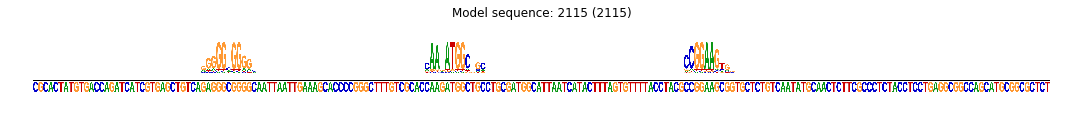

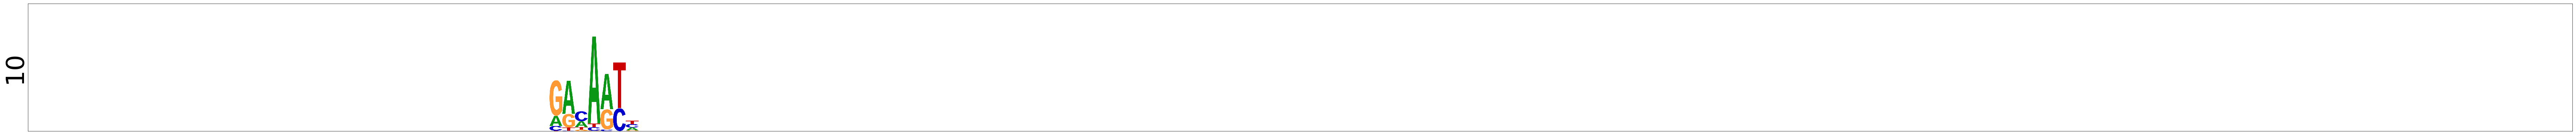

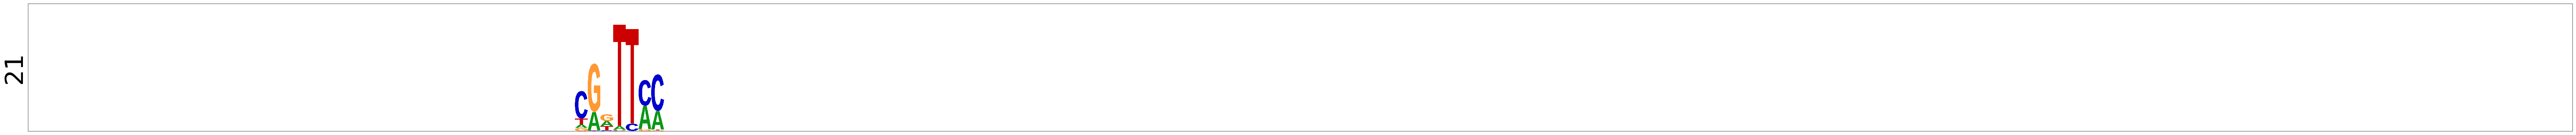

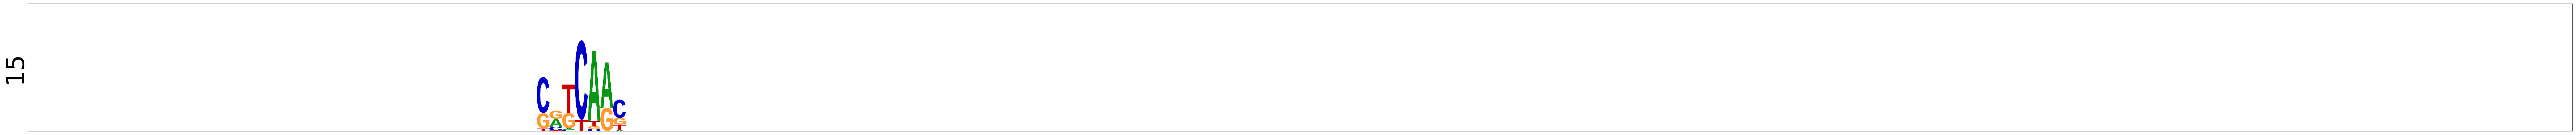

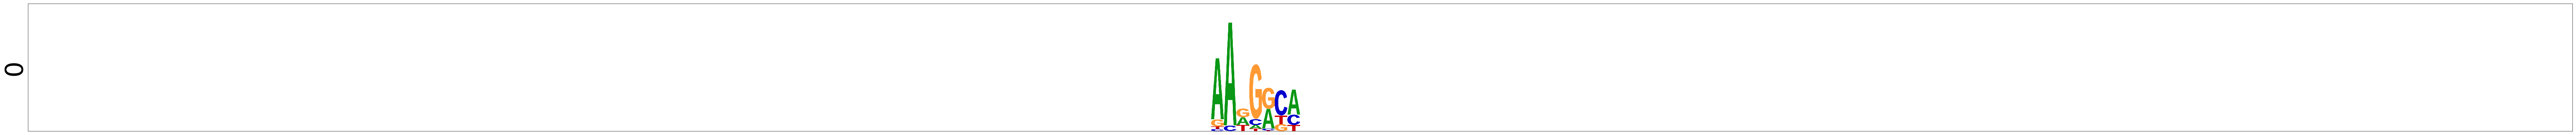

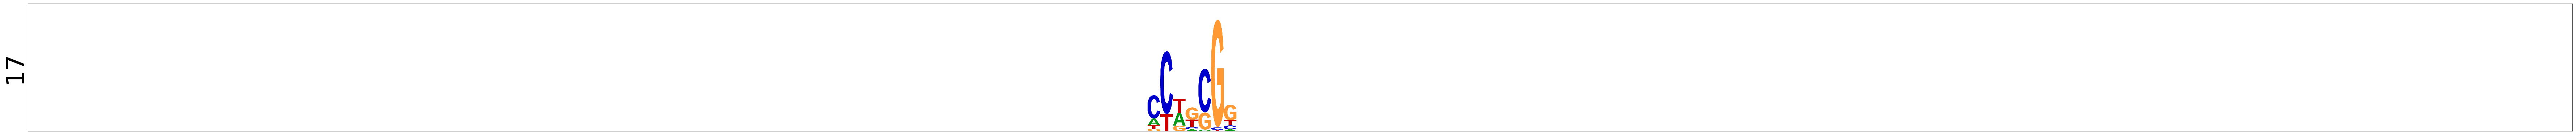

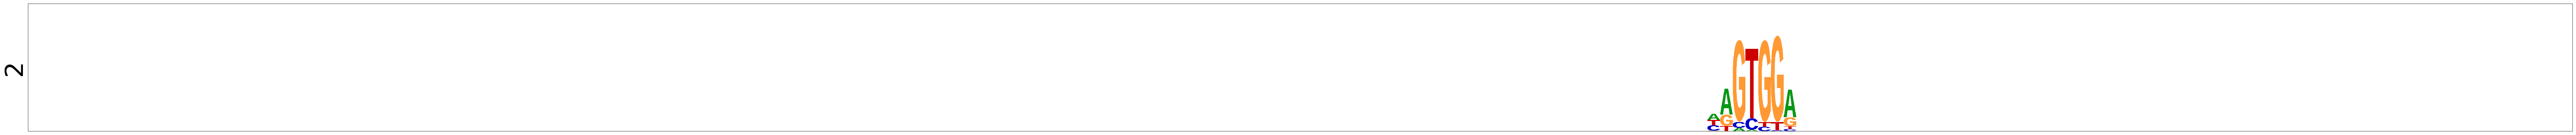

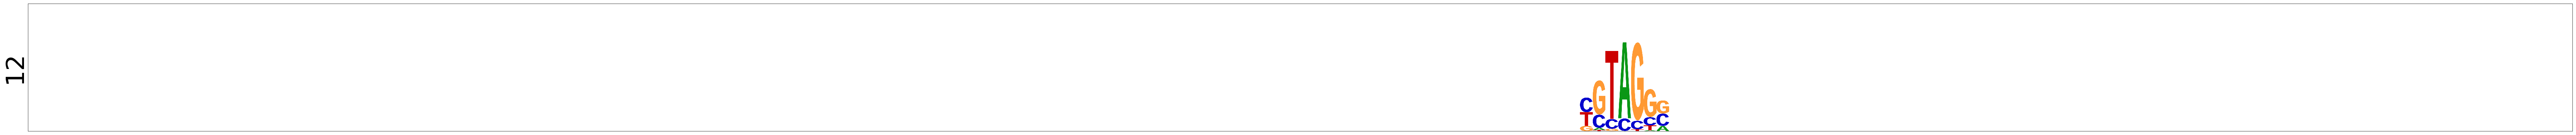

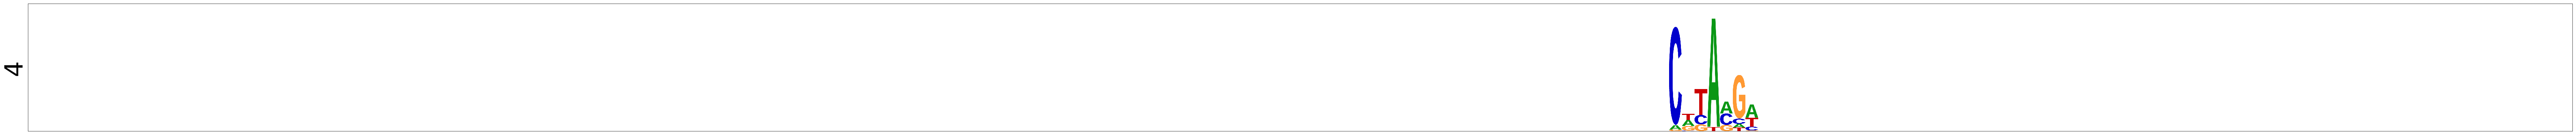

In [13]:
s = 2115
index = s
X = np.expand_dims(test['inputs'][s], axis=0)

X_model = test_model[s]

fig = plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)
    

layer = 'conv1d_0_active'

layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)[0]

sort_filter = np.argsort(np.squeeze(np.max(layer_act, axis=0)))[::-1]

#For each filter what is the index of the maximally activated neuron
max_idx = np.squeeze(np.argmax(layer_act, axis=0))

#Identify the desired filter
filters = [10,21,15,0,17,2,12,4]

fom_scores = []
for filter_index in filters:
#Get the FoM scores for each desired filter
    fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

num_plots = len(filters)

for i, scores in enumerate(fom_scores):
    fig = plt.figure(figsize=(100,3*len(sort_filter)))
    plt.title(str(layer), fontsize=20)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(scores, factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[i]), fontsize=70)

# DistNet Layer 2

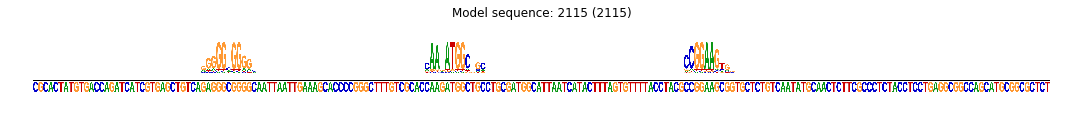

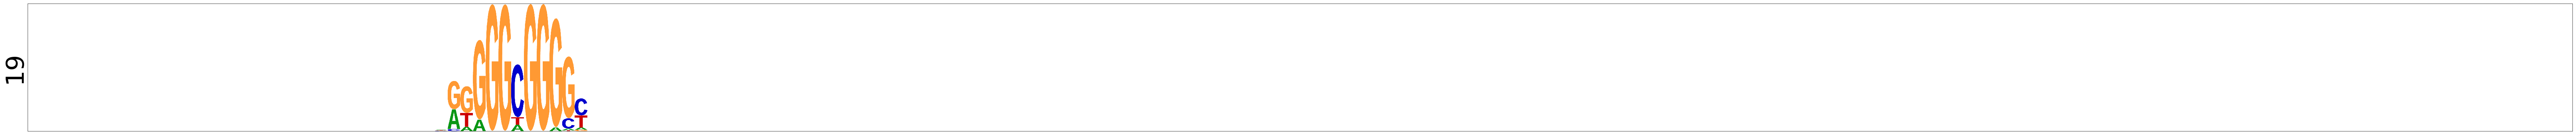

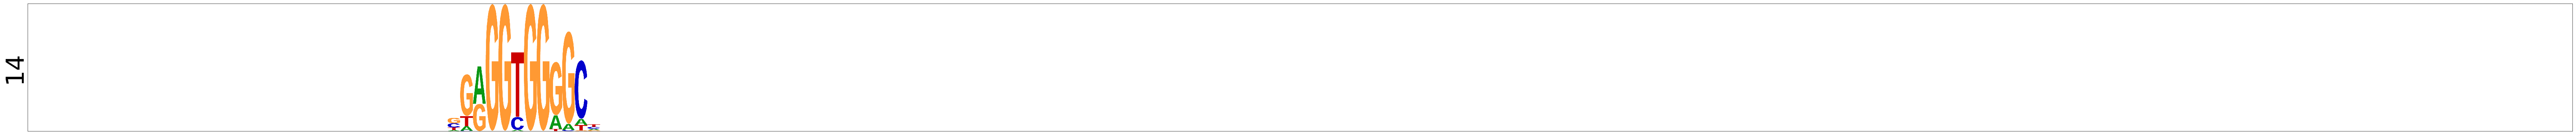

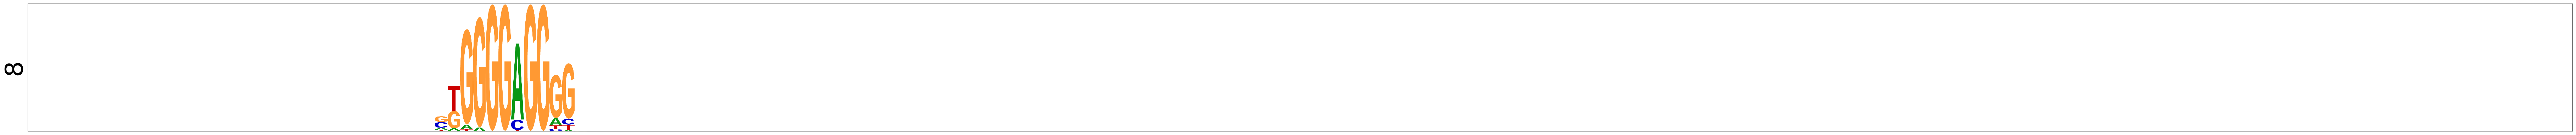

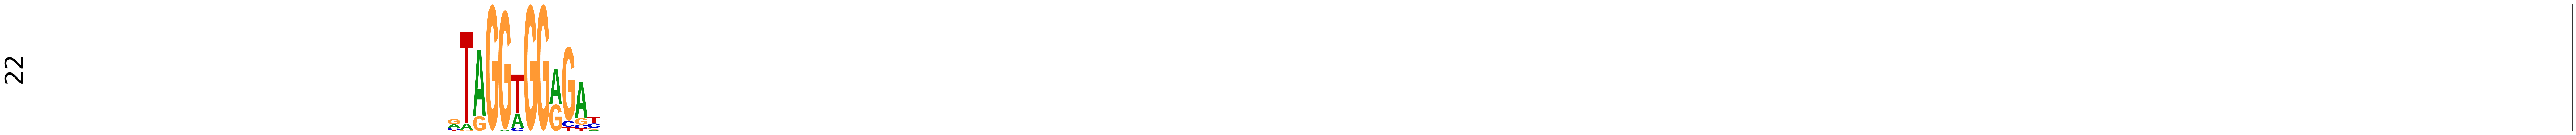

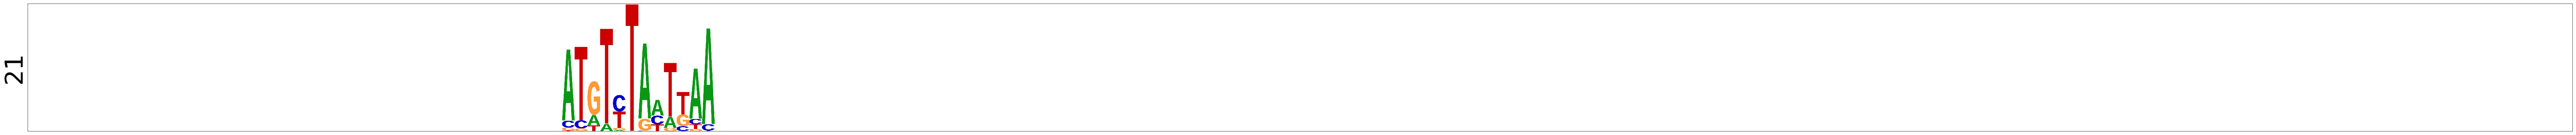

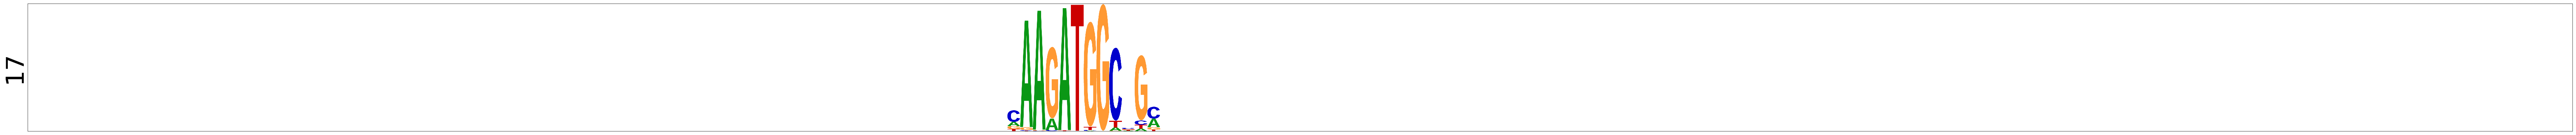

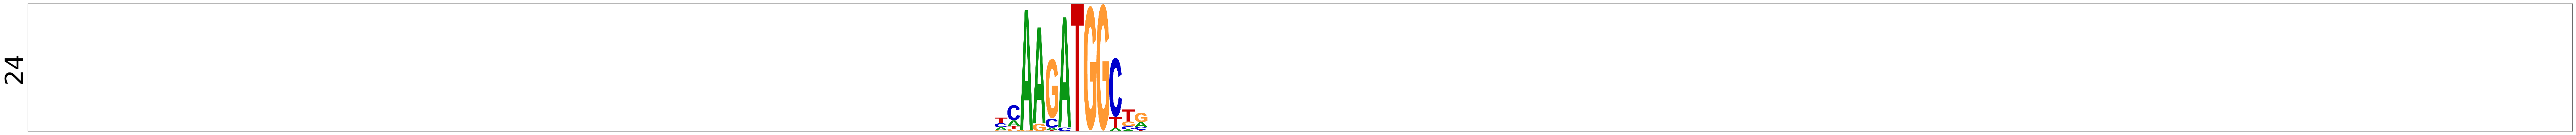

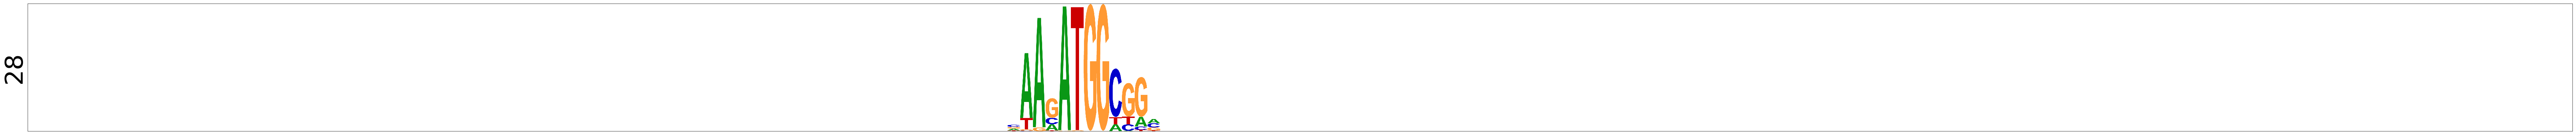

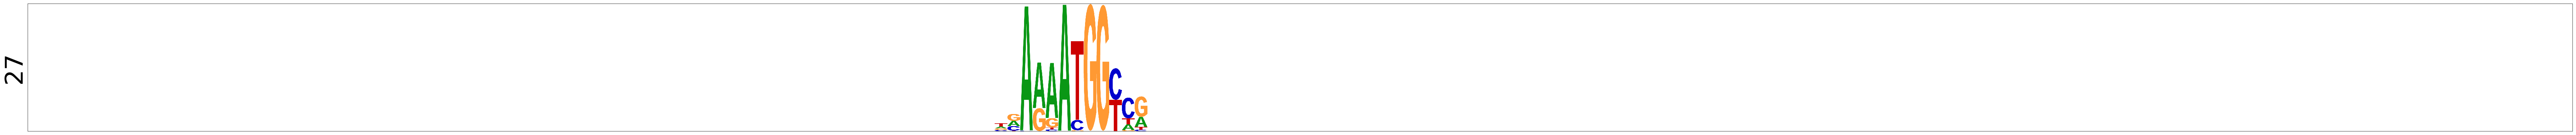

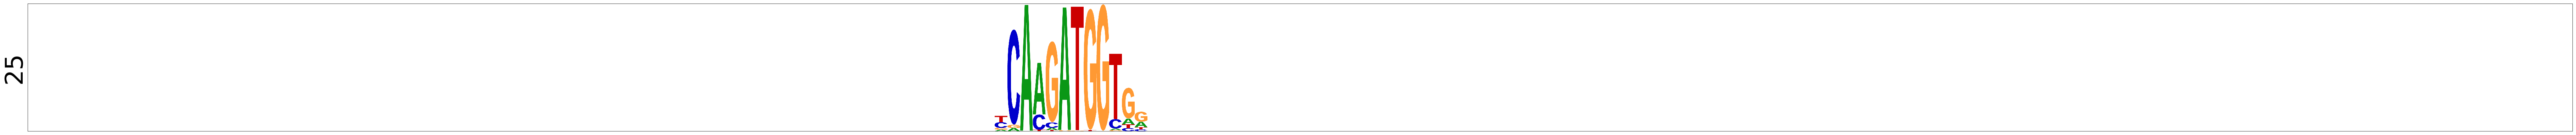

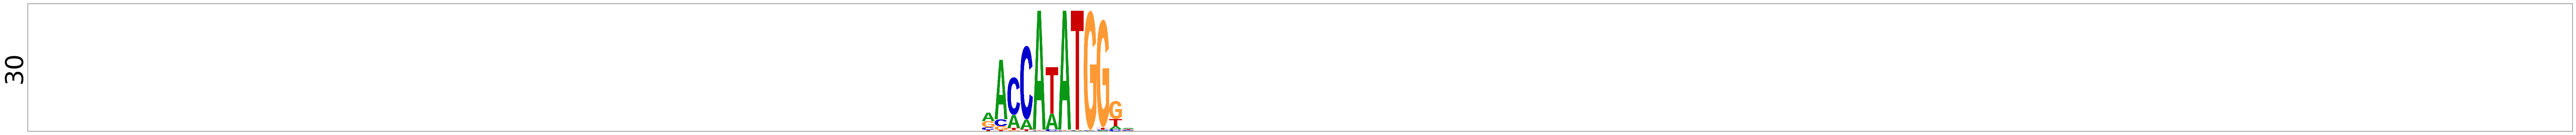

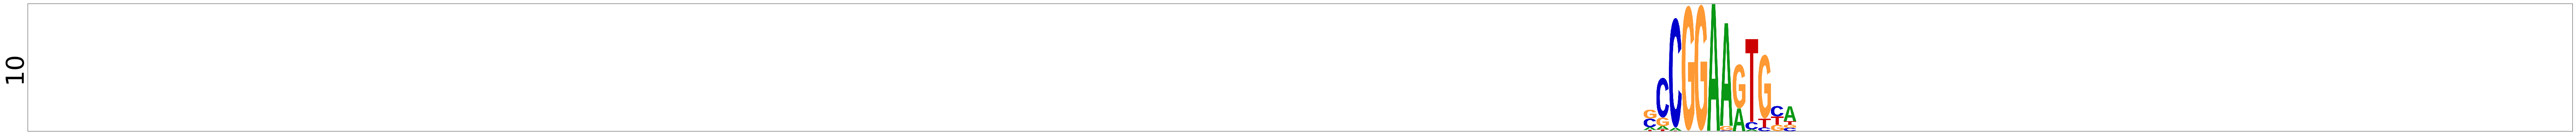

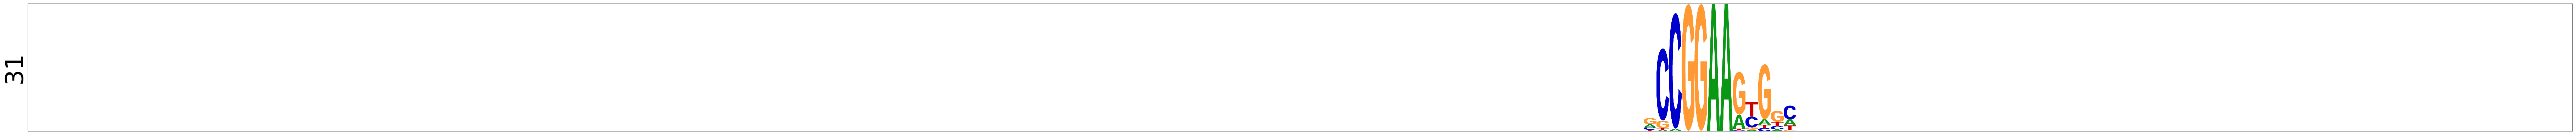

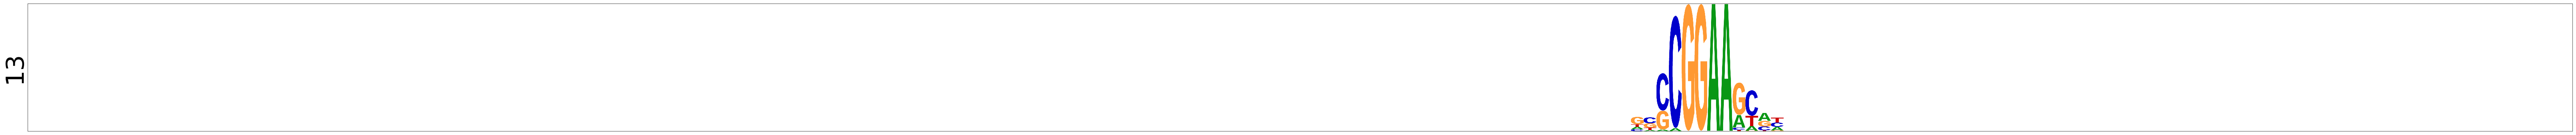

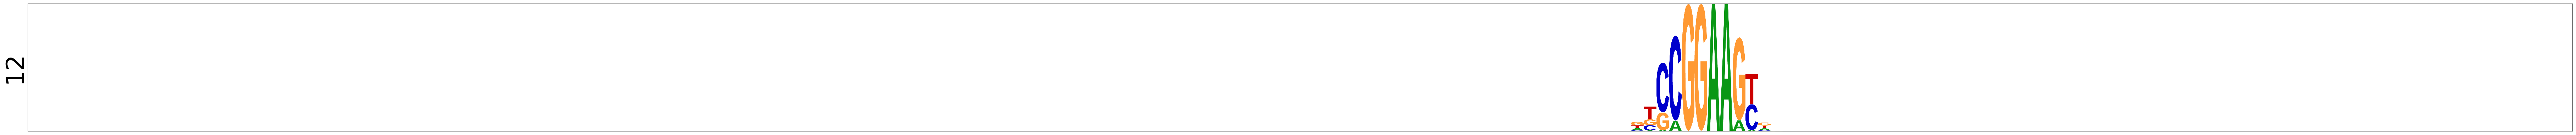

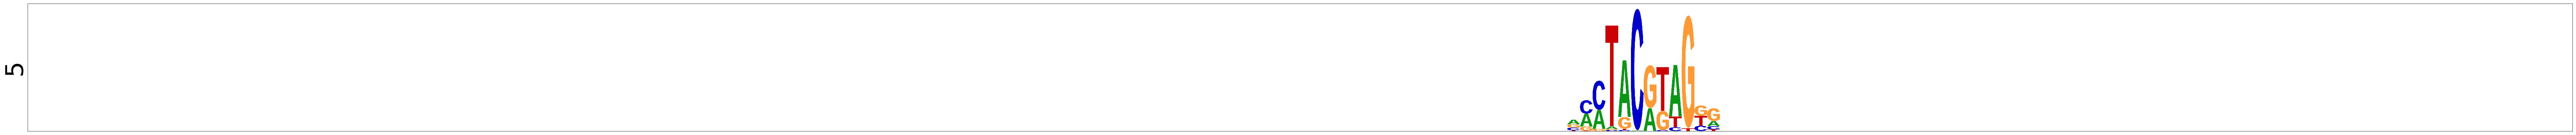

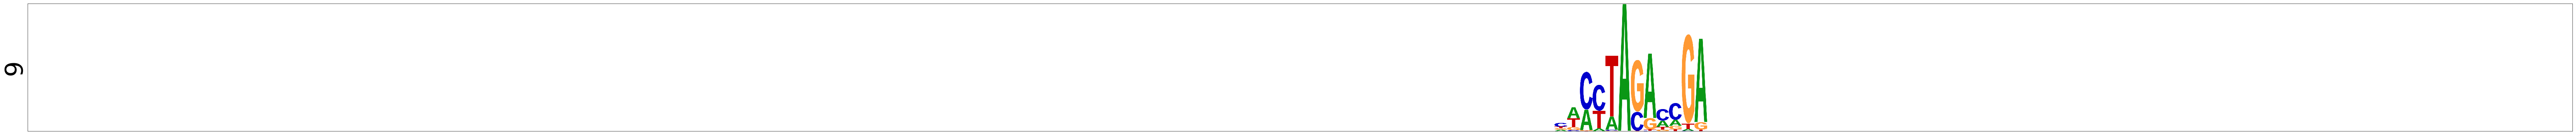

In [14]:
fig = plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)

layer = 'conv1d_1_active'

layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)[0]

sort_filter = np.argsort(np.squeeze(np.max(layer_act, axis=0)))[::-1]

#For each filter what is the index of the maximally activated neuron
max_idx = np.squeeze(np.argmax(layer_act, axis=0))

#Identify the desired filter
filters = [19,14,8,22,21,17,24,28,27,25,30,10,31,13,12,5,9]

fom_scores = []
for filter_index in filters:
#Get the FoM scores for each desired filter
    fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

num_plots = len(filters)

for i, scores in enumerate(fom_scores):
    fig = plt.figure(figsize=(100,3*len(sort_filter)))
    plt.title(str(layer), fontsize=20)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(scores, factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[i]), fontsize=70)

# DistNet Layer 3

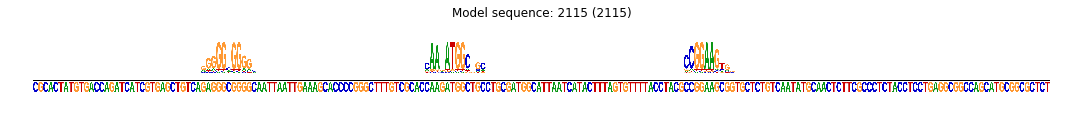

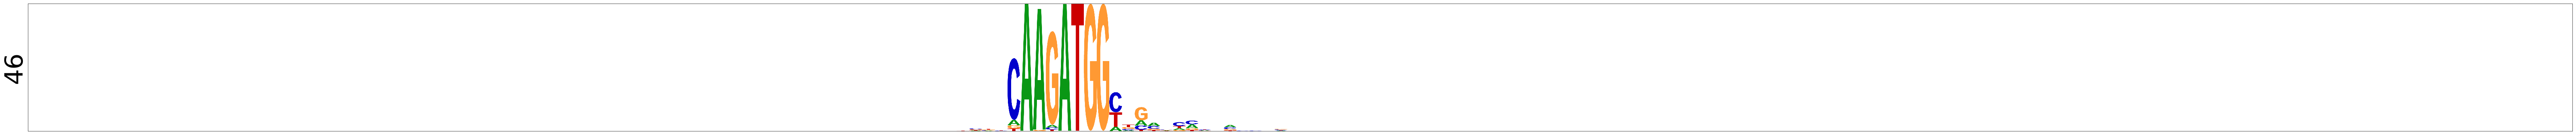

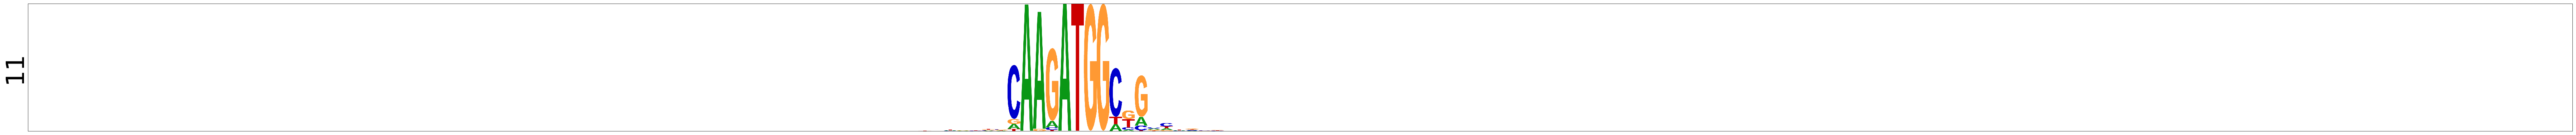

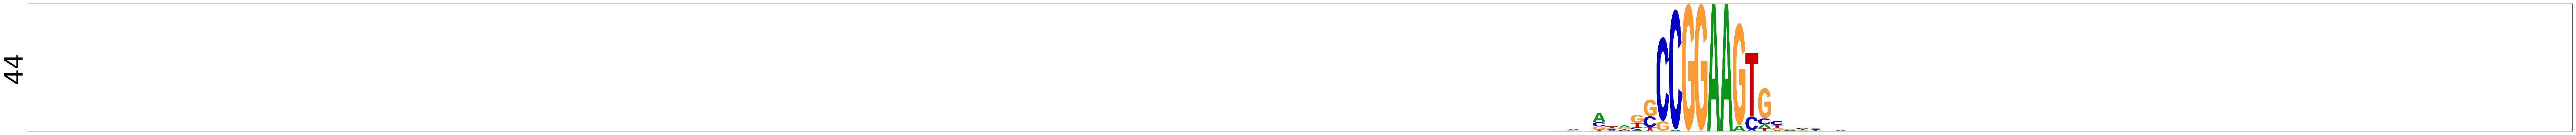

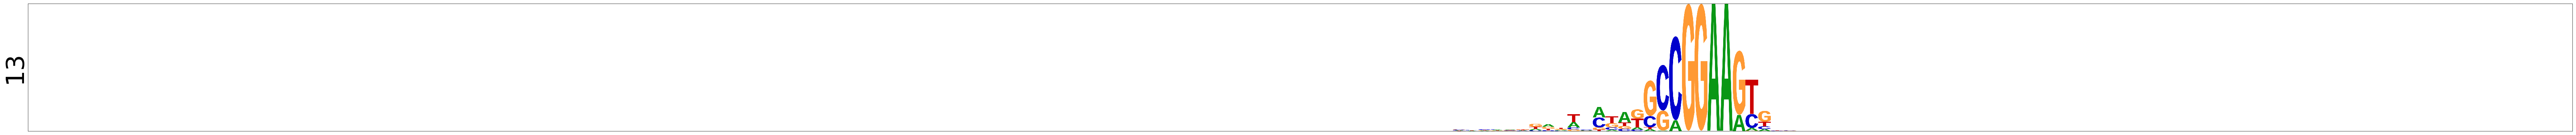

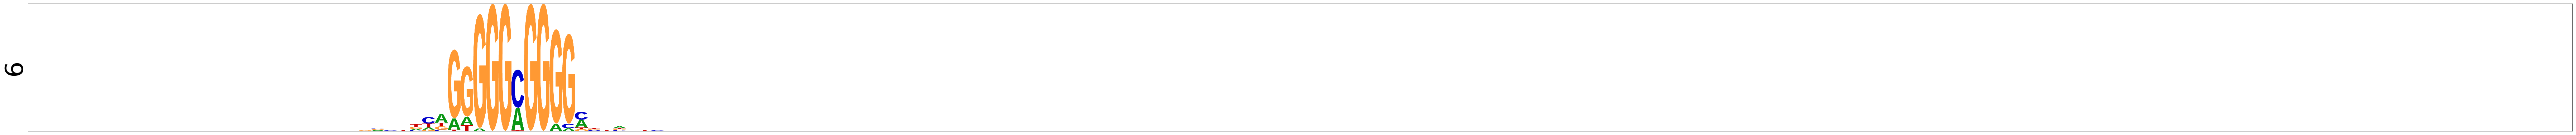

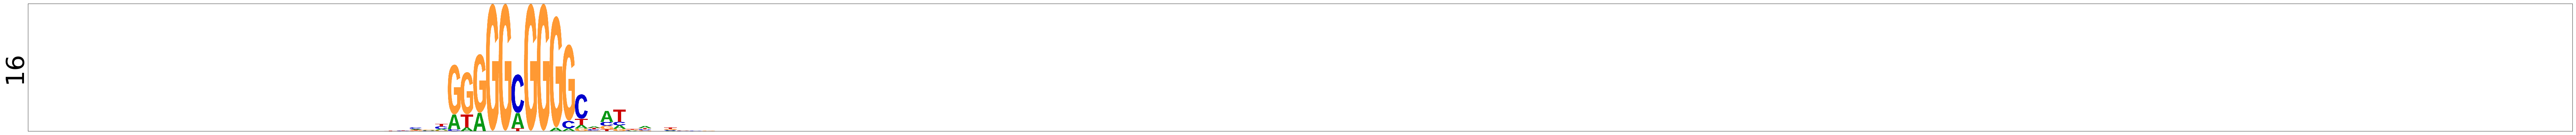

In [15]:
fig = plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)

layer = 'conv1d_2_active'

layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)[0]

sort_filter = np.argsort(np.squeeze(np.max(layer_act, axis=0)))[::-1]

#For each filter what is the index of the maximally activated neuron
max_idx = np.squeeze(np.argmax(layer_act, axis=0))

#Identify the desired filter
filters = [46,11,44,13,6,16]

fom_scores = []
for filter_index in filters:
#Get the FoM scores for each desired filter
    fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

num_plots = len(filters)

for i, scores in enumerate(fom_scores):
    fig = plt.figure(figsize=(100,3*len(sort_filter)))
    plt.title(str(layer), fontsize=20)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(scores, factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[i]), fontsize=70)

# DistNet Layer 4

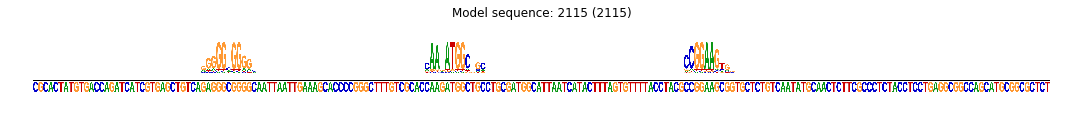

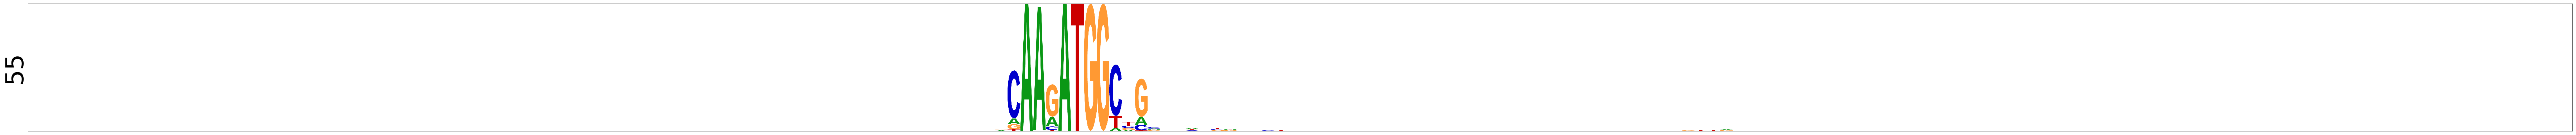

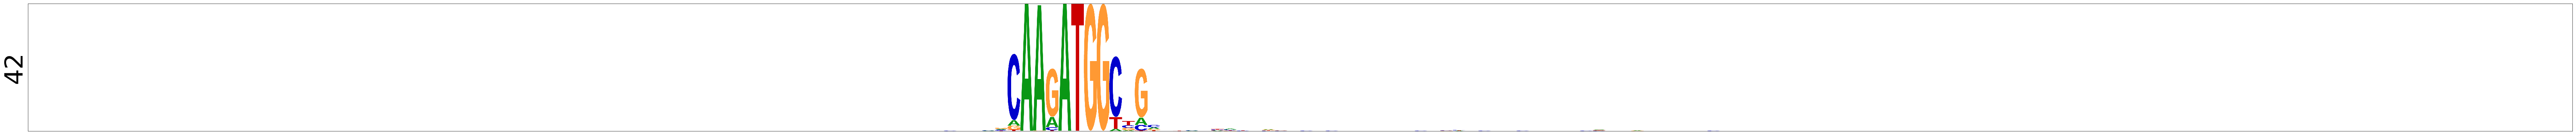

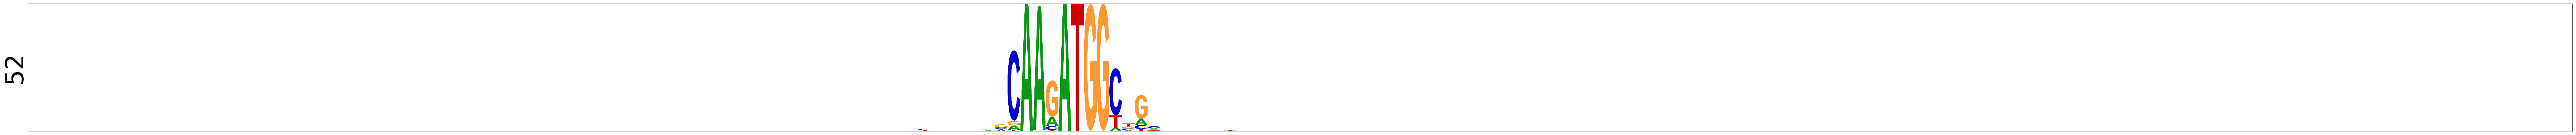

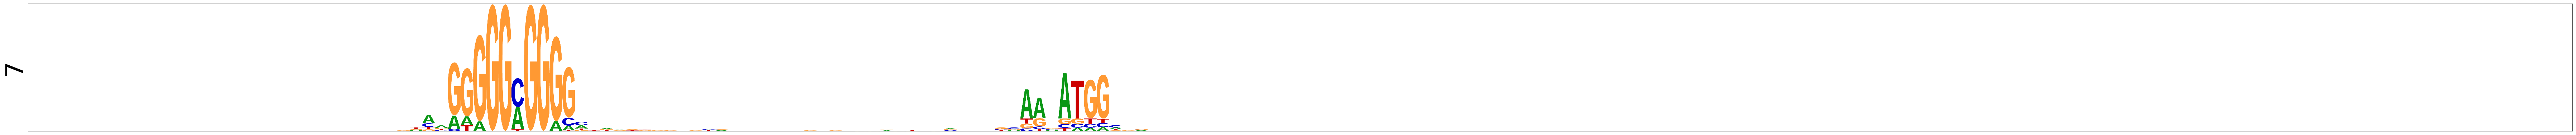

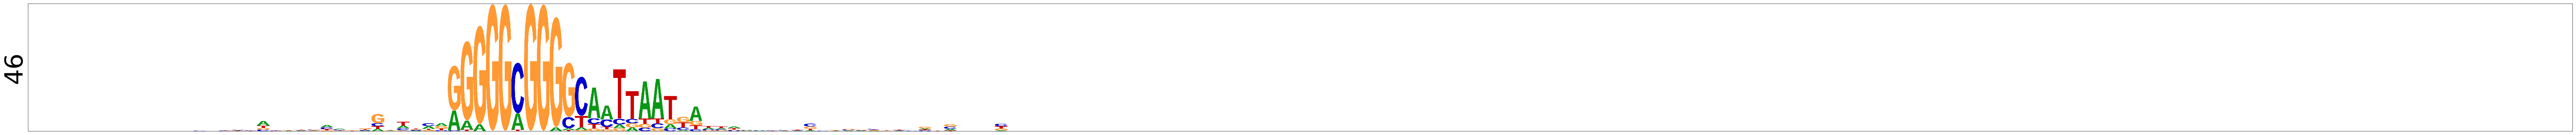

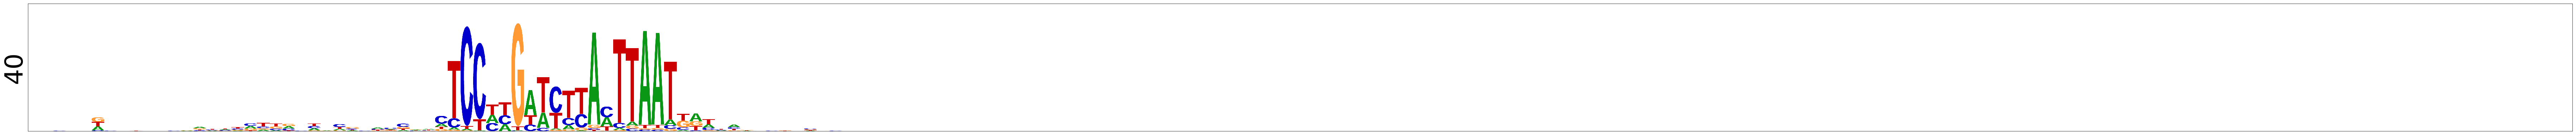

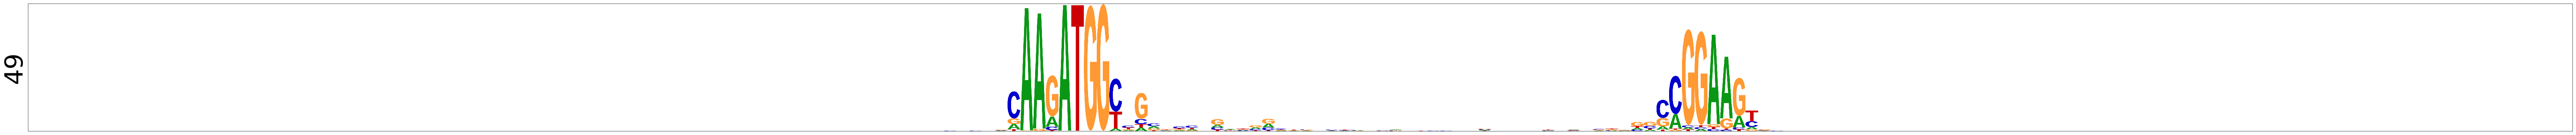

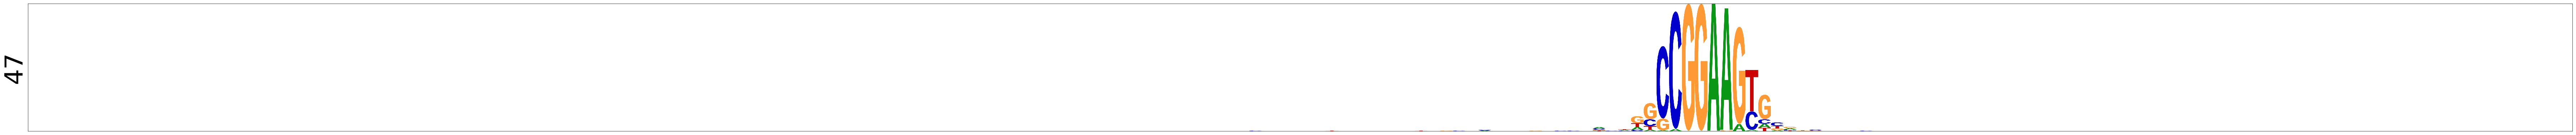

In [16]:
fig = plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)

layer = 'conv1d_3_active'

layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)[0]

sort_filter = np.argsort(np.squeeze(np.max(layer_act, axis=0)))[::-1]

#For each filter what is the index of the maximally activated neuron
max_idx = np.squeeze(np.argmax(layer_act, axis=0))

#Identify the desired filter
filters = [55,42,52,7,46,40,49,47]

fom_scores = []
for filter_index in filters:
#Get the FoM scores for each desired filter
    fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

num_plots = len(filters)

for i, scores in enumerate(fom_scores):
    fig = plt.figure(figsize=(100,3*len(sort_filter)))
    plt.title(str(layer), fontsize=20)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(scores, factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[i]), fontsize=70)

# DistNet Layer 5

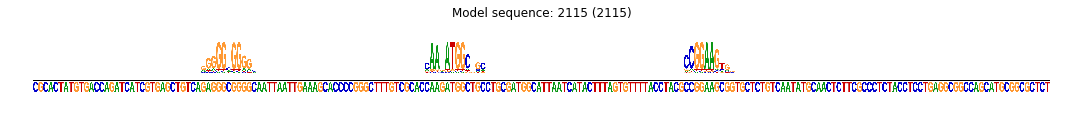

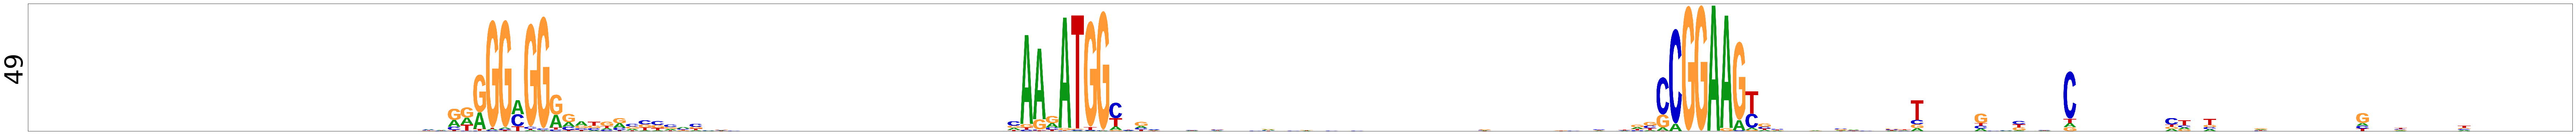

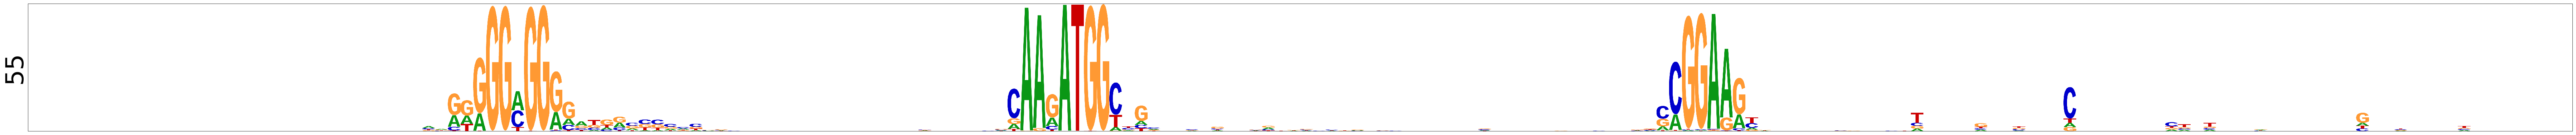

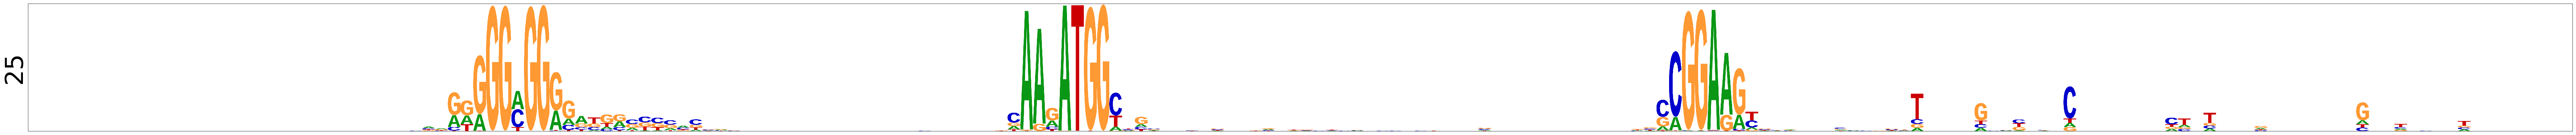

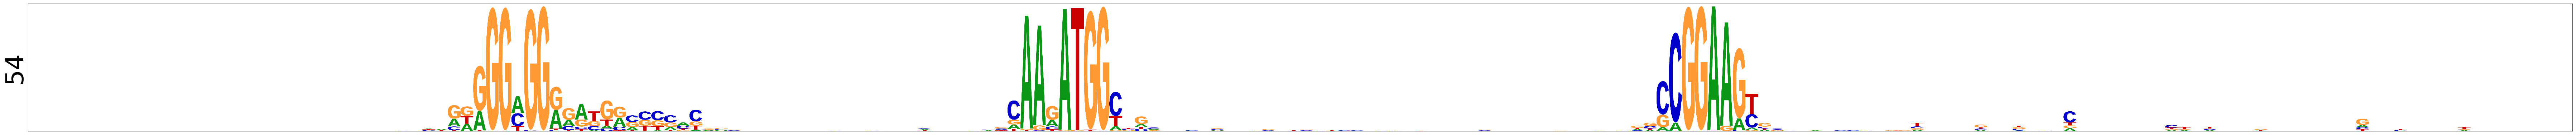

In [17]:
fig = plt.figure(figsize=(15,6))
plt.subplot(3,1,1)
plt.title('Model sequence: ' + str(index) + ' (%s)'%(s))
visualize.plot_seq_pos_saliency(np.squeeze(X).T, X_model, alphabet='dna', nt_width=50, norm_factor=3)

layer = 'conv1d_4_active'

layer_dict = {'inputs': X, 'targets': np.ones((X.shape[0], 1))}
layer_act = nntrainer.get_activations(sess, layer_dict, layer=layer)[0]

sort_filter = np.argsort(np.squeeze(np.max(layer_act, axis=0)))[::-1]

#For each filter what is the index of the maximally activated neuron
max_idx = np.squeeze(np.argmax(layer_act, axis=0))

#Identify the desired filter
filters = [49,55,25,54]

fom_scores = []
for filter_index in filters:
#Get the FoM scores for each desired filter
    fom_scores.append(fom_convsal(X, layer, 'dna', filter_index, max_idx, nntrainer, sess))

num_plots = len(filters)

for i, scores in enumerate(fom_scores):
    fig = plt.figure(figsize=(100,3*len(sort_filter)))
    plt.title(str(layer), fontsize=20)
    plt.subplot(num_plots,1,1)
    pwm = utils.normalize_pwm(scores, factor=12)
    logo = visualize.seq_logo(pwm, height=500, nt_width=100, norm=0, alphabet='dna')
    plt.imshow(logo)
    plt.xticks([])
    plt.yticks([])
    plt.ylabel(str(filters[i]), fontsize=70)